In [2]:
import skimage
import subprocess
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

<font size=3 > Extract each frame from original 720P frame and downsample to 360P and 180P

In [ ]:
video_path = 'water.mp4'
src_video = cv2.VideoCapture(video_path)
frame_id = 0
while src_video.isOpened():
    (flag, frame0) = src_video.read()  
    if not flag:
        break
    frame0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)
    frame0 = skimage.transform.resize(frame0, (180, 320)) * 255
    Image.fromarray(np.uint8(frame0)).save('180p/%04d.tiff' % frame_id)
    frame_id += 1

In [230]:
def calculate_psnr(img1, img2):
    SE_map = (img1-img2)**2
    cur_MSE = np.mean(SE_map)
    return 10*np.log10(1. / cur_MSE)

<font size=3 > Encoded by H264 codec and decoded to calculate PSNR

In [231]:
# br_list = np.linspace(10, 1000, 34, endpoint=True)
br_list = [259.5]
psnr_list = []
for i, br in enumerate(br_list):
    video_name = "360p_output/"+ str(br_list[i])+ "k.mp4"
    cmd = "ffmpeg -i 360p/%04d.tiff -b:v " + str(br_list[i]) +\
            "k -vcodec libx264 -s 640x360 -pix_fmt yuv420p "+ video_name
    subprocess.getoutput(cmd);
    # video_name = 'water.mp4'
    
    enc_video = cv2.VideoCapture(video_name)
    frame_idx = 0
    psnr = 0
    while enc_video.isOpened():
        (flag, frame0) = enc_video.read()  
        if not flag:
            break
        frame0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)
        frame_720p = "720p/%04d.tiff" % frame_idx
        frame1 = skimage.io.imread(frame_720p) / 255
        frame0 = skimage.transform.resize(frame0, frame1.shape)
        
        psnr += calculate_psnr(frame1, frame0)
        frame_idx += 1
    avg_psnr = psnr / (frame_idx+1)
    print("".join([str(br), "  ", str(avg_psnr)]))
    psnr_list.append(avg_psnr)
    

259.5  22.50743609713442


<font size=3 > PSNR and bitrates results

In [3]:
X_360p = np.linspace(10, 1000, 34, endpoint=True)
psnr_360p = [13.33775459612538, 17.067064351052867, 18.549769211621186, 19.796986149463038, 20.648446903889162,\
             21.269510618287995, 21.728208112292346, 22.108784125109672, 22.41884315097636, 22.682110155950756, \
             22.91374125217402, 23.09506262376732, 23.267595092899466, 23.414864611978743, 23.546550356650613, \
             23.66791360040711, 23.77506032952512, 23.877784656556024, 23.966646673459792, 24.048684601598737, \
             24.123583455080496, 24.196263277267725, 24.261973737481213, 24.32455790171479, 24.380668306537743, \
             24.43601795649802, 24.48767558304396, 24.535439616293, 24.57981526777312, 24.626593164446046, \
             24.665261093586427, 24.70413421239619, 24.74229957940116, 24.780168078969655]  
X_180p = np.append(np.ones(1).astype(np.uint8), np.linspace(5, 200, 14, endpoint=True).astype(np.uint8))
psnr_180p = [11.87504125372263, 12.889724674329264, 17.061805300149253, 18.23149854989578, 18.883221413913827, \
             19.25696745110691, 19.533684919313018, 19.730077081884293, 19.8821516286667, 19.99943109992574, \
             20.100097353662445, 20.184118157471246, 20.249520056031315, 20.31038747149071, 20.36317505301397] 
X_720p = np.linspace(200, 1500, 14, endpoint=True)
psnr_720p = [19.371563336089945, 21.533957174864007, 23.138562573928848, 24.276038397751798, 25.140559949828184, \
             25.8404473716614, 26.4029011870605, 26.87703217455676, 27.296583222411996, 27.657522260841652, \
             27.984342413922004, 28.27191610779295, 28.542948576623235, 28.783809770749915]

<font size=3 > Fit to polynomial 

In [4]:
fit_180p = np.polyfit(X_180p, psnr_180p, 6)
func_180p = np.poly1d(fit_180p)
print(func_180p)
y_180p=func_180p(X_180p)

            6             5             4             3           2
-4.439e-12 x + 3.198e-09 x - 9.179e-07 x + 0.0001339 x - 0.01054 x + 0.4421 x + 11.25


In [5]:
fit_360p = np.polyfit(X_360p, psnr_360p, 6)
func_360p = np.poly1d(fit_360p)
print(func_360p)
y_360p=func_360p(X_360p)

            6             5             4             3             2
-5.079e-16 x + 1.747e-12 x - 2.375e-09 x + 1.627e-06 x - 0.0005962 x + 0.1174 x + 12.63


In [6]:
fit_720p = np.polyfit(X_720p, psnr_720p, 4)
func_720p = np.poly1d(fit_720p)
print(func_720p)
y_720p=func_720p(X_720p)

            4           3             2
-6.357e-12 x + 2.8e-08 x - 4.724e-05 x + 0.03972 x + 13.13


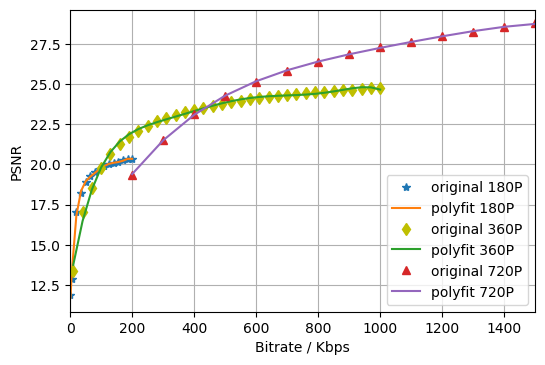

In [227]:
plt.figure(1)
plt.plot(X_180p, psnr_180p, '*',label='original 180P')
plt.plot(X_180p, y_180p,label='polyfit 180P')
plt.plot(X_360p, psnr_360p, 'yd',label='original 360P')
plt.plot(X_360p, y_360p,label='polyfit 360P')
plt.plot(X_720p, psnr_720p, '^',label='original 720P')
plt.plot(X_720p, y_720p,label='polyfit 720P')
plt.xlim([0, 1500])
plt.xlabel('Bitrate / Kbps')
plt.ylabel('PSNR')
plt.legend(loc=4)
# plt.title('polyfitting')
plt.rcParams['figure.dpi'] = 100
plt.grid(True)
plt.savefig("polyfit.png", dpi=200)
plt.show()

In [32]:
fit_180p_X = np.linspace(1, 200, 200, endpoint=True)
fit_360p_X = np.linspace(1, 700, 700, endpoint=True)
# fit_720p_X = np.linspace(200, 2000, 1800, endpoint=True)
fit_720p_X = np.linspace(1, 1500, 1500, endpoint=True)
fit_180p_Y = func_180p(fit_180p_X)
fit_360p_Y = func_360p(fit_360p_X)
fit_720p_Y = func_720p(fit_720p_X)

<font size=3 > Derive the second derivative to find the coordinates of the point where the derivative changes the most, and that is the so-called **"inflection point"**

In [33]:
from sympy import *
x1 = Symbol('x1')
# 9.858e-15 x - 1.139e-11 x + 5.13e-09 x - 1.186e-06 x + 0.0001532 x
# - 0.01121 x + 0.4511 x + 11.23
# -4.439e-12 x + 3.198e-09 x - 9.179e-07 x + 0.0001339 x - 0.01054 x + 0.4421 x + 11.25
function_180p = -4.439e-12*(x1**6) + 3.198e-09*(x1**5) - 9.179e-07*(x1**4) + 0.0001339*(x1**3) - 0.01054*(x1**2)+ 0.4421*x1 + 11.25
yprime_180p = function_180p.diff(x1).diff(x1)
print(yprime_180p)
f_180p = lambdify(x1, yprime_180p, 'numpy')
o_180p = f_180p(fit_180p_X)
print(np.argmax(o_180p[0:100]))

x2 = Symbol('x2')
# -5.079e-16 x + 1.747e-12 x - 2.375e-09 x + 1.627e-06 x - 0.0005962 x + 0.1174 x + 12.63
function_360p = -5.079e-16*(x2**6) + 1.747e-12*(x2**5) - 2.375e-09*(x2**4) + 1.627e-06*(x2**3) - 0.0005962*(x2**2) + 0.1174*x2 + 12.63
yprime_360p = function_360p.diff(x2).diff(x2)
print(yprime_360p)
f_360p = lambdify(x2, yprime_360p, 'numpy')
o_360p = f_360p(fit_360p_X)
print(np.argmax(o_360p[0:200]))

x3 = Symbol('x3')
function_720p = -6.357e-12*(x3**4) + 2.8e-08*(x3**3) - 4.724e-05*(x3**2) + 0.03972*x3 + 13.13
yprime_720p = function_720p.diff(x3).diff(x3)
print(yprime_720p)
f_720p = lambdify(x3, yprime_720p, 'numpy')
o_720p = f_720p(fit_720p_X)
print(np.argmax(o_720p))


-1.3317e-10*x1**4 + 6.396e-8*x1**3 - 1.10148e-5*x1**2 + 0.0008034*x1 - 0.02108
77
-1.5237e-14*x2**4 + 3.494e-11*x2**3 - 2.85e-8*x2**2 + 9.762e-6*x2 - 0.0011924
199
-7.6284e-11*x3**2 + 1.68e-7*x3 - 9.448e-5
1100


In [229]:
x_ch = [45, 180, 730, 990, 1000, 1200]
y_ch = [fit_180p_Y[45], fit_360p_Y[180], fit_720p_Y[730], fit_720p_Y[990],fit_720p_Y[1000],fit_720p_Y[1200]]
z_ch = np.polyfit(x_ch, y_ch, 4)
p_ch = np.poly1d(z_ch)
yvals_ch=p_ch(np.linspace(1, 1000, 1000))
print(p_ch)

            4            3             2
-1.312e-11 x + 4.28e-08 x - 5.152e-05 x + 0.0316 x + 17.51


In [138]:
dis_360p = np.abs(yvals_ch[10:700] - fit_360p_Y[10:700])
dis_720p = np.abs(yvals_ch[10:700] - fit_720p_Y[10:700])
i = 0
while dis_360p[i]<dis_720p[i]:
    i += 1
print(i)

dis_360p = np.abs(yvals_ch[10:180] - fit_360p_Y[10:180])
dis_180p = np.abs(yvals_ch[10:180] - fit_180p_Y[10:180])
j = 0
while dis_360p[j]>dis_180p[j]:
    j += 1
print(j)

421
88


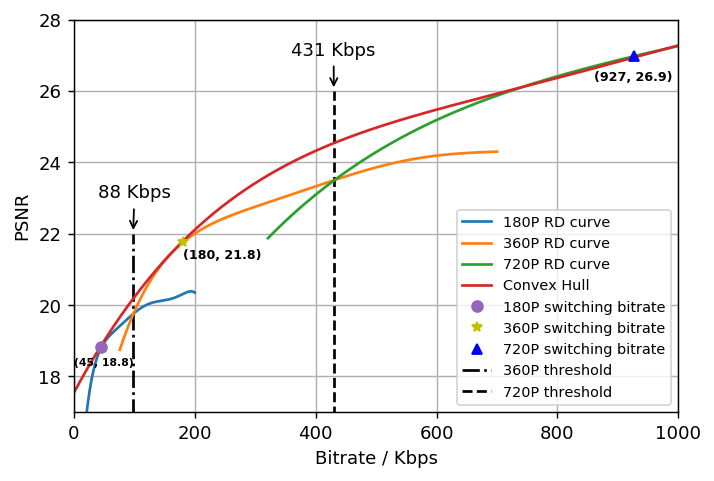

In [233]:
plt.figure(2)
plt.rcParams['figure.dpi'] = 130 
plt.ylim([17, 28])
plt.xlim([0, 1000])
plt.plot(fit_180p_X, fit_180p_Y, label="180P RD curve")
plt.plot(fit_360p_X[75:700], fit_360p_Y[75:700], label="360P RD curve")
plt.plot(fit_720p_X[320:1200], fit_720p_Y[320:1200], label='720P RD curve')
plt.plot(yvals_ch, label='Convex Hull')
plt.plot(45, fit_180p_Y[45], "o",label='180P switching bitrate')
plt.plot(180, fit_360p_Y[180], "y*",label='360P switching bitrate')
plt.plot(927, fit_720p_Y[927], "b^",label='720P switching bitrate')
plt.vlines(98, 0, 22, label='360P threshold', linestyles = "-.")
plt.vlines(431, 0, 26, label='720P threshold', linestyles = "dashed")
# plt.vlines(260, 0, 26, label='720P threshold', linestyles = "dashed")
plt.annotate('88 Kbps', xy=(98, 22), xytext=(40, 23), arrowprops=dict(arrowstyle="->"))
plt.annotate('431 Kbps', xy=(430, 26), xytext=(360, 27), arrowprops=dict(arrowstyle="->"))
plt.text(1, 18.3,'(45, 18.8)',fontdict={'size':'6', 'weight':'semibold'})
plt.text(180, 21.3,'(180, 21.8)',fontdict={'size':'7', 'weight':'semibold'})
plt.text(860, 26.3,'(927, 26.9)',fontdict={'size':'7', 'weight':'semibold'})
plt.grid(True)
plt.xlabel('Bitrate / Kbps')
plt.ylabel('PSNR')
plt.legend(prop={'size': 8})
plt.savefig("RD.png", dpi=200)
plt.show()